In [104]:
"""
intro_qiskit.ipynb. Modified excercise from
    Hands-On Quantum Machine Learning With Python
    Volume 1: Get Started by Dr. Frank Zickert
    Copyright © 2021 Dr. Frank Zickert, pyqml.com
Chapter 3 Qubit and Quantum States
I added Accuracy and Matthews Correlation Coefficient metrics,
I corrected bugs in the use of rankings as probabilities
and in the use of probabilities to set quantum states.
"""
None

In [105]:
from functools import reduce
from math import sqrt, pi, cos, sin
import matplotlib.pyplot as plt
import numpy as np
from qiskit import execute, Aer, QuantumCircuit
from qiskit.visualization import plot_histogram
import random
from scipy.stats import spearmanr
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, matthews_corrcoef

In [106]:
def get_state(theta):
    """returns a valid state vector"""
    return [cos(theta/2), sin(theta/2)]

# play with the values for theta to get a feeling
theta = -pi/3 # affects the probabilities

qc = QuantumCircuit(1)
#initial_state = [0, 1]  # |1>
#initial_state = [1/sqrt(2), 1/sqrt(2)]  # |+>
#initial_state = [1/2, sqrt(3)/2] # 75% true
initial_state = get_state(theta)
qc.initialize(initial_state, 0)
#qc.measure_all()

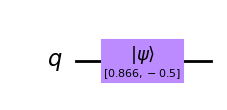

In [107]:
qc.draw(output='mpl')

In [108]:
backend = Aer.get_backend('statevector_simulator')
result = execute(qc,backend).result()

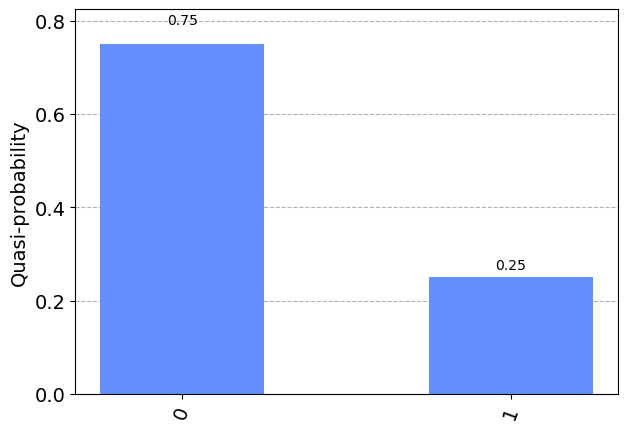

In [109]:
counts = result.get_counts()
plot_histogram(counts)

In [110]:
def pqc_classify(backend, passenger_state):
    """backend −− a qiskit backend to run the quantum circuit at
    passenger_state −− a valid quantum state vector"""

    # Create a quantum circuit with one qubit
    qc = QuantumCircuit(1)

    # Define state |Psi> and initialize the circuit
    qc.initialize(passenger_state, 0)
    qc.measure_all()

    # Run the quantum circuit
    result = execute(qc, backend).result()

    # Get the counts, these are either {'0': 1} or {'1': 1}
    counts = result.get_counts(qc)

    # Get the bit 0 or 1
    return int(list(map(lambda item: item[0], counts.items()))[0])

In [111]:
# These numpy arrays were written by titanic_ml after data cleaning.
with open('titanic/train.npy', 'rb') as f:
    train_input = np.load(f)
    train_labels = np.load(f)
with open('titanic/test.npy', 'rb') as f:
    test_input = np.load(f)
    test_labels = np.load(f)

In [112]:
random.seed(a=None, version=2)
def random_classify(passenger):
    return random.randint(0, 1)

def specificity(matrix):
    """Specificity := TN / All Actual Negatives.
    Confusion matrix is [[TN, FP], [FN, TP]] ."""
    den = matrix[0][0] + matrix[0][1]
    return matrix[0][0] / den if 0 < den else 0

def npv(matrix):
    """Negative Predictive Value := TN / All Predicted Negatives
    Confusion matrix is [[TN, FP], [FN, TP]] ."""
    den = matrix[0][0] + matrix[1][0]
    return matrix[0][0] / den if 0 < den else 0

def run(f_classify, x):
    return list(map(f_classify, x))

def classifier_report(name, run, classify, inputs, labels):
    cr_predictions = run(classify, inputs)
    cr_cm = confusion_matrix(labels, cr_predictions)
    cr_prec = precision_score(labels, cr_predictions)
    cr_rec = recall_score(labels, cr_predictions)
    cr_spec = specificity(cr_cm)
    cr_npv = npv(cr_cm)
    cr_info = 0.25*(cr_prec + cr_rec + cr_spec + cr_npv)
    cr_acc = accuracy_score(labels, cr_predictions)
    cr_mcc = matthews_corrcoef(labels, cr_predictions)
    print(f'{name}: prec {cr_prec:.2f}, rec {cr_rec:.2f}, spec {cr_spec:.2f}, npv {cr_npv:.2f}'
          f', info {cr_info:.2f}, acc {cr_acc:.2f}, mcc {cr_mcc:.2f}')

In [113]:
backend = Aer.get_backend('statevector_simulator')
initial_state = [1/sqrt(2), 1/sqrt(2)]
classifier_report("Random PQC", run,
                lambda passenger: pqc_classify(backend, initial_state),
                train_input, train_labels)
# Output stats on random 50-50 choice for each passenger

Random PQC: prec 0.37, rec 0.46, spec 0.52, npv 0.62, info 0.49, acc 0.50, mcc -0.02


In [114]:
def pqc(backend, quantum_state):
    """
    backend −− a qiskit backend to run the quantum circuit at
    quantum_state −− a valid quantum state vector
    returns the counts of the measurement
    """
    # Create a quantum circuit with one qubit
    qc = QuantumCircuit(1)

    # Define state |Psi> and initialize the circuit
    qc.initialize(quantum_state, 0)

    # Measure the qubit
    qc.measure_all()

    # run the quantum circuit
    result = execute(qc,backend).result()

    # Get the counts, these are either {'0': 1} or {'1': 1}
    counts = result.get_counts(qc)
    return counts

def post_process(counts):
    """
    counts −− the result of the quantum circuit execution
    returns the prediction
    """
    return int(list(map(lambda item: item[0], counts.items()))[0])

def weigh_feature(feature, weight):
    """
    feature −− the single value of a passenger's feature
    weight −− the overall weight of this feature
    returns the weighted feature
    """
    return feature * weight

def get_overall_probability(features, weights):
    """
    features −− list of the features of a passenger
    weights −− list of all features' weights
    """
    return reduce(
            lambda result, data: result + weigh_feature(*data), zip(features, weights),
            0)

# Separate the training data into a list of the columns
columns = [list(map(lambda passenger: passenger[i], train_input)) for i in range(0,7)]

# Calculate the correlation coefficient for each column
correlations = list(map(lambda col: spearmanr(col, train_labels)[0], columns))

# Return correlations on: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked
# Losers are 3rd class; males; and embarked at Southampton.
# Winners are number of siblings, spouse; number of parents, children; cost of ticket
correlations

[-0.32775463966656226,
 -0.5244017735458312,
 -0.08466252799952526,
 0.07792938671633483,
 0.13784778790972818,
 0.29989196388440625,
 -0.15729149549859364]

In [115]:
def pre_process_weighted(passenger):
    """
    passenger −− the normalized (array of numeric data) passenger data
    returns a valid quantum state
    """
    # Calculate the overall probability
    mu = get_overall_probability(passenger, correlations)
    #print(f'overall probability {mu}')

    # theta between 0 (|0>) and pi (|1>)
    quantum_state = get_state((1 - mu) * pi)
    return quantum_state
# My comment: No, mu is not a probability and usually negative,
# so theta is usually greater than pi.
# Another bug is that qubit probability does not vary linearly with theta.

In [116]:
backend = Aer.get_backend('statevector_simulator')
classifier_report("Variational", run,
                lambda passenger: post_process(pqc(backend, pre_process_weighted(passenger))),
                train_input,
                train_labels)
# output stats on variable random choice based on features for each passenger

Variational: prec 0.67, rec 0.61, spec 0.82, npv 0.78, info 0.72, acc 0.74, mcc 0.44


In [117]:
classifier_report("Variational−Test",  run,
                lambda passenger: post_process(pqc(backend, pre_process_weighted(passenger))),
                test_input,
                test_labels)

Variational−Test: prec 0.80, rec 0.64, spec 0.89, npv 0.78, info 0.78, acc 0.79, mcc 0.55


raw "probability" quantiles [-1.08317614 -1.00225357 -0.780902   -0.41856172  0.26310345]
	 mean -0.6744385497636031
scaled probability quantiles [0.         0.06010829 0.22452553 0.49366745 1.        ]


Text(0.5, 1.0, 'Scaled training probabilities colored by whether survived')

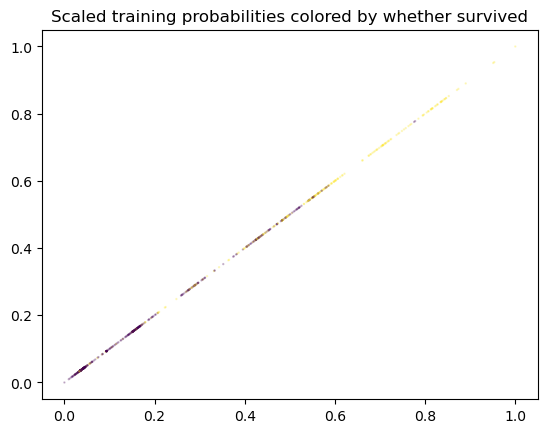

In [118]:
# My addition: try to improve scores with better probability calculation.
probs = np.array([get_overall_probability(p, correlations) for p in train_input])
print(f'raw "probability" quantiles {np.quantile(probs, [0, .25, .5, .75, 1])}')
print(f'\t mean {np.mean(probs)}')
# Raw probs are not probabilities, merely rankings and mostly negative; need to be scaled.

scaled_probs = (probs - probs.min()) / (probs.max() - probs.min())
# This is fairly good: 3rd quartile is slightly less than 0.5, close to survival rate.
print(f'scaled probability quantiles {np.quantile(scaled_probs, [0, .25, .5, .75, 1])}')
plt.scatter(scaled_probs, scaled_probs, c=train_labels, alpha=.25, s=.5)
plt.title('Scaled training probabilities colored by whether survived')

In [120]:
# My addition: Apply scaled probabilities to simulated quantum prediction
def pqc_p(backend, prob):
    """
    backend −− a qiskit backend to run the quantum circuit at
    prob −− probability of survival
    returns the counts of the measurement
    """
    # Create a quantum circuit with one qubit
    qc = QuantumCircuit(1)

    # Define state |Psi> directly from prabability and initialize the circuit
    quantum_state = (sqrt(1. - prob), sqrt(prob))
    qc.initialize(quantum_state, 0)

    # Measure the qubit
    qc.measure_all()

    # run the quantum circuit
    result = execute(qc,backend).result()

    # Get the counts, these are either {'0': 1} or {'1': 1}
    counts = result.get_counts(qc)
    return counts

classifier_report("Scaled-Variational",  run,
                lambda prob: post_process(pqc_p(backend, prob)),
                scaled_probs,
                train_labels)
'''
Although my results have slightly lower scores than the ones in the book,
I believe they are more correct, because I use proabilities rather than rankings,
and I correctly apply the probabilities to quantum states.
'''
None

Scaled-Variational: prec 0.65, rec 0.52, spec 0.83, npv 0.74, info 0.68, acc 0.71, mcc 0.37
